In [1]:
p <- c("vegan","ade4","reshape2","ggplot2","pheatmap","dplyr","randomForest", "vegan", "ape",
       "cluster", "clusterSim", "plotly", "corrplot", "pROC", "cowplot", "gridExtra", "grid")
usePackage <- function(p) {
  if (!is.element(p, installed.packages()[,1]))
    install.packages(p, dep=TRUE, repos="https://cloud.r-project.org/")
  suppressWarnings(suppressMessages(invisible(require(p, character.only=TRUE))))
}
invisible(lapply(p, usePackage))
source("metabo_util.R")
#-------------------------------


In [2]:
setwd('~/MyProjects/SoH_project/multi-omics')

## Data input

In [3]:
filename1<-"PlaqueMS275.txt"
prefix1<-"metabolomics"
metadata.filename1<-"PlaqueMS275_Map.txt"
filename2="SoH261.taxa.genus.Abd.xls"
prefix2<-"microbiome-genus"
metadata.filename2<-"SoH261_Map.txt"
filename3<-"SoH192_cytokines.txt"
prefix3<-"cytokines"
metadata.filename3<-"SoH192_Map.txt"

outputPath<-"./Procustes_analysis/"
dir.create(outputPath)
f1<-read.table(filename1,header=TRUE,sep="\t",row.names=1, quote=""); f1<-f1[order(rownames(f1)), ]
f2<-read.table(filename2,header=TRUE,sep="\t",row.names=1); f2<-f2[order(rownames(f2)), ]
f3<-read.table(filename3,header=TRUE,sep="\t",row.names=1); f3<-f3[order(rownames(f3)), ]
m1<-read.table(metadata.filename1,header=T,sep="\t",row.names=1); m1<-m1[order(rownames(m1)), ]
m2<-read.table(metadata.filename2,header=T,sep="\t",row.names=1); m2<-m2[order(rownames(m2)), ]
m3<-read.table(metadata.filename3,header=T,sep="\t",row.names=1); m3<-m3[order(rownames(m3)), ]

cat("The order of samples in the metabolome data and metadata are equal:", all.equal(rownames(f1), rownames(m1)), "\n")
cat("The order of samples in the microbiome data and metadata are equal:", all.equal(rownames(f2), rownames(m2)), "\n")
cat("The order of samples in the cytokines data and metadata are equal:", all.equal(rownames(f3), rownames(m3)))


Warning message in dir.create(outputPath):
“'./Procustes_analysis' already exists”

The order of samples in the metabolome data and metadata are equal: TRUE 
The order of samples in the microbiome data and metadata are equal: TRUE 
The order of samples in the cytokines data and metadata are equal: TRUE

## To identify intersected sample IDs

In [4]:

Shared_SampleIDs<-intersect(rownames(f1), rownames(f2))
f1_s<-f1[Shared_SampleIDs,]; 
m1_s<-m1[Shared_SampleIDs,]; 
cat("The order of samples in the metabolome data and metadata are equal:", all.equal(rownames(f1_s), rownames(m1_s)), "\n")
f2_s<-f2[Shared_SampleIDs,]; 
m2_s<-m2[Shared_SampleIDs,]; 
cat("The order of samples in the microbiome data and metadata are equal:", all.equal(rownames(f2_s), rownames(m2_s)), "\n")
#library("graphics")
dt<-table(m2[, c("Timepoint", "Group", "Gender", "Smoking")])
#mosaicplot(dt, shade = TRUE, las=2, main = "SoH clinical study")

The order of samples in the metabolome data and metadata are equal: TRUE 
The order of samples in the microbiome data and metadata are equal: TRUE 


In [5]:
length(union(m1$Host_ID, m2$Host_ID))

[1] 40

## Clinical measurements

In [6]:
clinical_md<-"all_clincal_metadata.txt"
cmd<-read.table(clinical_md, header=TRUE, sep="\t", row.names=1, comment.char = "")#; cmd<-cmd[order(rownames(cmd)), ]

In [7]:
head(cmd)

Host_ID Timepoint Visit Bleeding Mazza  Halimeter
CSD2017073_3003_DAY_21 3003    DAY-21    T1    15       1.3571  94      
CSD2017073_3003_DAY_14 3003    DAY-14    T2     5       1.1429  39      
CSD2017073_3003_DAY_07 3003    DAY-07    T3     2       1.0357  97      
CSD2017073_3003_DAY0   3003    DAY0      T4     1       1.0179 171      
CSD2017073_3003_DAY01  3003    DAY01     T5     0       1.0000 141      
CSD2017073_3003_DAY03  3003    DAY03     T6     1       1.0357  87      
                       Group        Age Gender Smoking Remark.1              
CSD2017073_3003_DAY_21 High_bleeder 38  F      N       CSD2017073_3003_DAY_21
CSD2017073_3003_DAY_14 High_bleeder 38  F      N       CSD2017073_3003_DAY_14
CSD2017073_3003_DAY_07 High_bleeder 38  F      N       CSD2017073_3003_DAY_07
CSD2017073_3003_DAY0   High_bleeder 38  F      N       CSD2017073_3003_DAY0  
CSD2017073_3003_DAY01  High_bleeder 38  F      N       CSD2017073_3003_DAY01 
CSD2017073_3003_DAY03  High_bleeder 38  F      N       CSD2017073_3003_DAY03 
                       Delta_R30 Delta_R70 Delta_R120 sps
CSD2017073_3003_DAY_21 105       25        8          1  
CSD2017073_3003_DAY_14 9         1         0          0  
CSD2017073_3003_DAY_07 8         1         0          0  
CSD2017073_3003_DAY0   35        1         0          0  
CSD2017073_3003_DAY01  128       13        0          1  
CSD2017073_3003_DAY03  39        4         0          0

In [8]:
nlevels(as.factor(cmd$Host_ID))

[1] 40

In [9]:
levels(cmd$Timepoint)

[1] "DAY-07" "DAY-14" "DAY-21" "DAY0"   "DAY01"  "DAY03"  "DAY07"  "DAY14" 
[9] "DAY28"

In [10]:
cmd$Timepoint<-factor(cmd$Timepoint, levels=c('DAY-21', 'DAY-14', 'DAY-07', 'DAY0','DAY01','DAY03','DAY07','DAY14','DAY28'), ordered = TRUE)

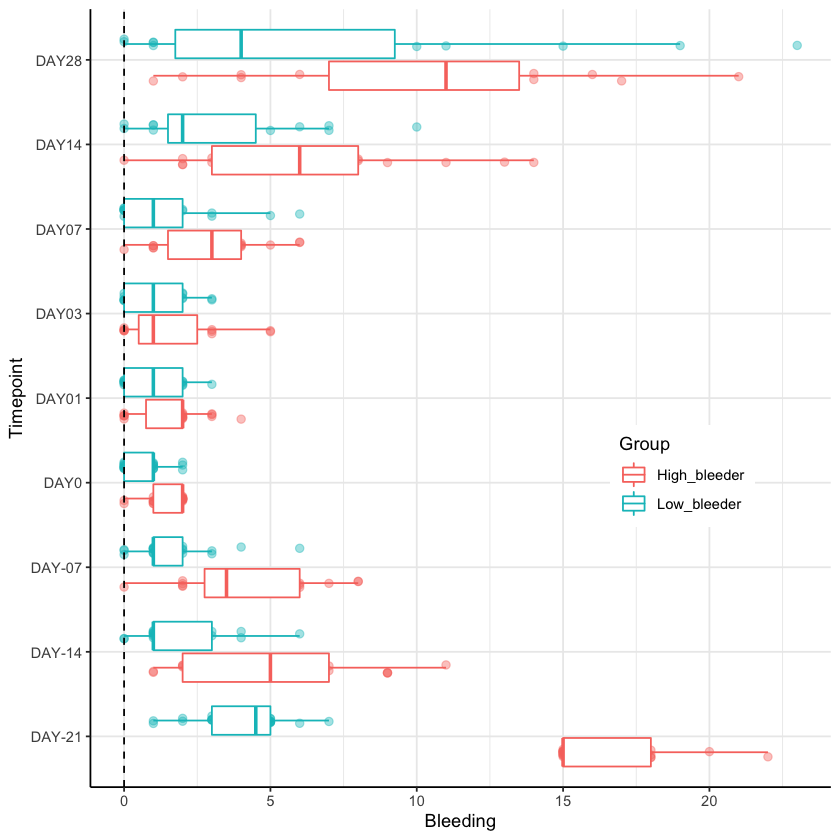

In [11]:
c_bp<-ggplot(cmd, aes(x=Timepoint, y=Bleeding)) +
    geom_jitter(aes(color=Group), position=position_jitterdodge(jitter.width= 0.2,dodge.width = 0.8),size=2,alpha=0.4) +
    geom_boxplot(aes(color=Group), outlier.shape = NA) + 
    #scale_color_manual(values=c("", ""))+
    #geom_point(aes(fill=Group), pch = 21, position = position_dodge(width = 0.8), size=1,alpha=0.6)+
    ylab("Bleeding")+
    coord_flip()+
    geom_hline(yintercept=0, linetype="dashed")+
    theme_bw()+
    theme(
        axis.line = element_line(color="black"),
        strip.background = element_rect(colour = "white"),
        panel.border = element_blank())+
theme(legend.position=c(0.8, 0.4))
#theme(legend.position="none")
c_bp
ggsave(filename=paste(outputPath,"/Bleeding_by_Group.png",sep=""), plot=c_bp, width=3, height=5)

## PCoA  

In [12]:
#--------------------------------------------------
# Distance matrix
#--------------------------------------------------
dm_f1<-vegdist(f1_s, method = "bray")
dm_f2<-vegdist(f2_s, method = "bray")


In [13]:
dm_f3<-vegdist(f3, method = "bray")

In [14]:
res_f1 <- pcoa(dm_f1)
res_f2 <- pcoa(dm_f2)

summary(res_f1)
summary(res_f2)


           Length Class      Mode     
correction     2  -none-     character
note           1  -none-     character
values         6  data.frame list     
vectors    30537  -none-     numeric  
trace          1  -none-     numeric  

           Length Class      Mode     
correction     2  -none-     character
note           1  -none-     character
values         6  data.frame list     
vectors    26100  -none-     numeric  
trace          1  -none-     numeric  

In [15]:
res_f1

$correction
[1] "none" "1"   

$note
[1] "No correction was applied to the negative eigenvalues"

$values
      Eigenvalues  Relative_eig Rel_corr_eig Broken_stick Cum_corr_eig
1    2.612141e+00  2.809758e-01 0.0912806232 2.369102e-02   0.09128062
2    1.152193e+00  1.239360e-01 0.0417345202 1.983001e-02   0.13301514
3    1.022804e+00  1.100182e-01 0.0373434731 1.789951e-02   0.17035862
4    6.498446e-01  6.990073e-02 0.0246863910 1.661251e-02   0.19504501
5    5.415107e-01  5.824776e-02 0.0210098751 1.564726e-02   0.21605488
6    3.969827e-01  4.270156e-02 0.0161050460 1.487506e-02   0.23215993
7    3.518317e-01  3.784489e-02 0.0145727634 1.423156e-02   0.24673269
8    2.865362e-01  3.082136e-02 0.0123568374 1.367998e-02   0.25908953
9    2.366340e-01  2.545360e-02 0.0106633106 1.319736e-02   0.26975284
10   2.140400e-01  2.302328e-02 0.0098965429 1.276836e-02   0.27964938
11   2.020956e-01  2.173848e-02 0.0094911873 1.238226e-02   0.28914057
12   1.812238e-01  1.949339e-02 0.00878286

## PCoA: metabolome

In [30]:
vectors_f1<-data.frame(Name=rownames(res_f1$vectors), res_f1$vectors)
vectors_f1<-merge(m1_s, vectors_f1, by=c(0, 0))
var_perc<-round(res_f1$values$Relative_eig*100, 2)
head(vectors_f1)

Row.names Group        Visit Host_ID Timepoint Day Bleeding Mazza  Halimeter
1 H3003_0   High_bleeder T4    H3003   DAY0        0  1       1.0179 171      
2 H3003_1   High_bleeder T5    H3003   DAY01       1  0       1.0000 141      
3 H3003_14  High_bleeder T8    H3003   DAY14      14  2       1.0357 110      
4 H3003_21b High_bleeder T1    H3003   DAY-21    -21 15       1.3571  94      
5 H3003_28  High_bleeder T9    H3003   DAY28      28  2       1.0536 120      
6 H3003_3   High_bleeder T6    H3003   DAY03       3  1       1.0357  87      
  Age ⋯ Axis.108      Axis.109      Axis.110      Axis.111      Axis.112     
1 38  ⋯  0.0003489991 -0.0005040788  0.0036433916  0.0004223743  0.0024678761
2 38  ⋯  0.0001060215  0.0011160988 -0.0038513103 -0.0013363724  0.0006149864
3 38  ⋯  0.0025047043 -0.0018410405 -0.0001888027  0.0025431618  0.0018617825
4 38  ⋯ -0.0027945767 -0.0012145766  0.0005500924 -0.0003615127 -0.0021360846
5 38  ⋯ -0.0064076641  0.0019998953 -0.0017102301  0.0036288144  0.0002677347
6 38  ⋯  0.0009594669  0.0006496589  0.0012184968  0.0010220688  0.0018647084
  Axis.113      Axis.114      Axis.115      Axis.116      Axis.117     
1 -0.0022383396  0.0001391176  1.574496e-04  0.0004309122  2.962365e-05
2  0.0012976961 -0.0003701666 -2.297380e-06  0.0001696158  3.288095e-05
3 -0.0006979422 -0.0016110008  1.909516e-03 -0.0021672254  9.505170e-05
4  0.0022231779  0.0019225939 -6.508897e-05  0.0004704827  1.065362e-04
5  0.0012586932  0.0012248067 -1.330258e-03  0.0021138558 -9.347035e-07
6 -0.0012130355 -0.0001284055  3.531349e-04 -0.0011553862  5.796550e-05

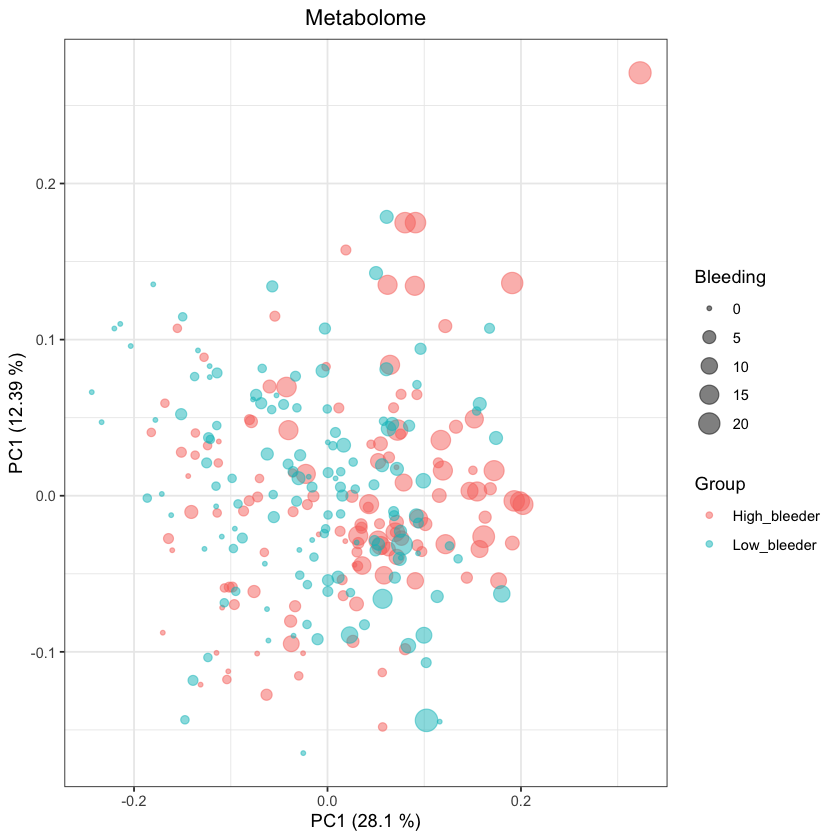

In [31]:
p<-ggplot(data=vectors_f1, aes(x=Axis.1, y=Axis.2, color=Group)) + 
   geom_point(aes(color=Group, size=Bleeding), alpha=0.5) +
   #scale_colour_manual(values = viridis::viridis(3))+
ggtitle("Metabolome") +
#geom_path(aes(group=Host_ID), alpha=0.1)+
xlab(paste("PC1 (", var_perc[1], " %)", sep=""))+
ylab(paste("PC1 (", var_perc[2], " %)", sep=""))+
theme_bw()+
theme(plot.title = element_text(hjust = 0.5))

p
ggsave(filename=paste(outputPath,"/PCoA_metabolome_by_Group.png",sep=""), plot=p, width=5, height=4)

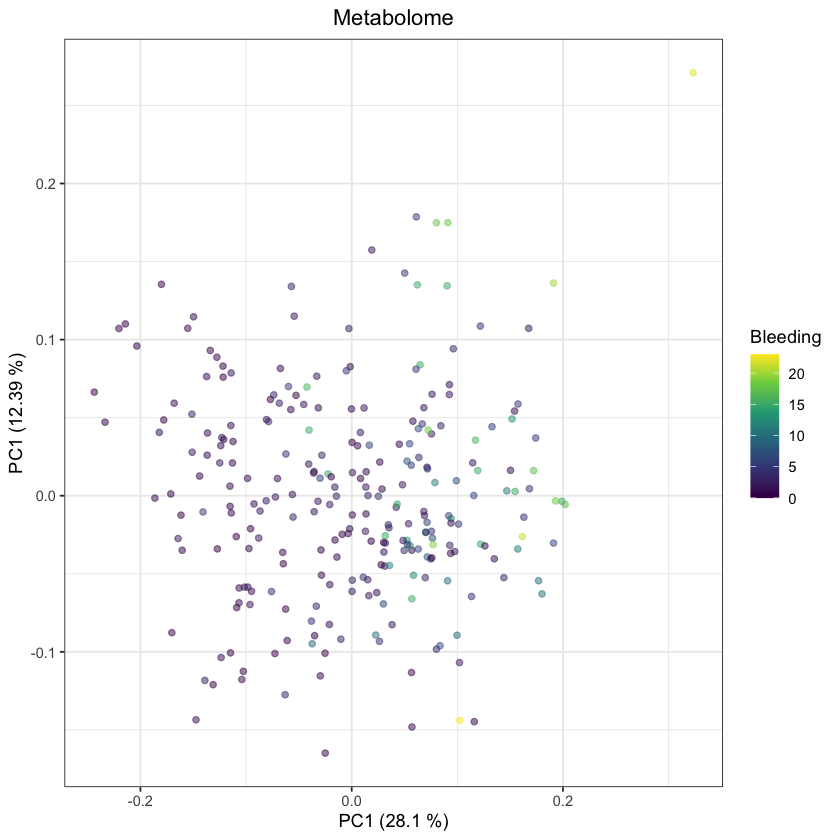

In [32]:
p_pcoa1<-ggplot(data=vectors_f1, aes(x=Axis.1, y=Axis.2, color=Bleeding)) + 
   geom_point(aes(color=Bleeding), alpha=0.5) +
   scale_color_continuous(type = "viridis")+
   ggtitle("Metabolome") +
#geom_text(aes(label=Target_field),hjust=0, vjust=0, alpha=0.3, size=1)+
#geom_path(aes(group=Host_ID), alpha=0.1)+
xlab(paste("PC1 (", var_perc[1], " %)", sep=""))+
ylab(paste("PC1 (", var_perc[2], " %)", sep=""))+
theme_bw()+
theme(plot.title = element_text(hjust = 0.5))#+
#
p_pcoa1
ggsave(filename=paste(outputPath,"/PCoA_metabolome_by_Bleeding.pdf",sep=""), plot=p_pcoa1, width=5, height=4)

In [33]:
vectors_f2<-data.frame(Name=rownames(res_f2$vectors), res_f2$vectors)
vectors_f2<-merge(m1_s, vectors_f2, by=c(0, 0))
var_perc<-round(res_f2$values$Relative_eig*100, 2)
head(vectors_f2)

Row.names Group        Visit Host_ID Timepoint Day Bleeding Mazza  Halimeter
1 H3003_0   High_bleeder T4    H3003   DAY0        0  1       1.0179 171      
2 H3003_1   High_bleeder T5    H3003   DAY01       1  0       1.0000 141      
3 H3003_14  High_bleeder T8    H3003   DAY14      14  2       1.0357 110      
4 H3003_21b High_bleeder T1    H3003   DAY-21    -21 15       1.3571  94      
5 H3003_28  High_bleeder T9    H3003   DAY28      28  2       1.0536 120      
6 H3003_3   High_bleeder T6    H3003   DAY03       3  1       1.0357  87      
  Age ⋯ Axis.91       Axis.92       Axis.93       Axis.94       Axis.95      
1 38  ⋯ -0.0028988430 -8.656391e-04  0.0003727976 -0.0006692803 -0.0003916603
2 38  ⋯ -0.0063536406 -5.236679e-03 -0.0027928107 -0.0021769701  0.0038553886
3 38  ⋯ -0.0012506236 -2.905377e-03  0.0023134126  0.0009360989 -0.0031441086
4 38  ⋯ -0.0017440457  5.395884e-03 -0.0023390607  0.0026633091  0.0004656823
5 38  ⋯ -0.0044953542  7.908465e-05 -0.0028828748  0.0085896162  0.0003571643
6 38  ⋯ -0.0001651513  1.728974e-03 -0.0019558705 -0.0005159543  0.0022128899
  Axis.96       Axis.97       Axis.98       Axis.99       Axis.100     
1 -0.0053266550 -0.0019827922  0.0008252916  0.0004109284 -0.0001674170
2 -0.0072836393 -0.0016559420 -0.0011580231 -0.0003998593  0.0011986113
3 -0.0023054521 -0.0009885383  0.0020646066  0.0009240758  0.0004805261
4 -0.0005157074  0.0007894022  0.0011012507 -0.0022687909  0.0007737749
5  0.0010035734  0.0016500161 -0.0042560098 -0.0020742558 -0.0009152917
6  0.0011548152  0.0026504684  0.0011801984 -0.0001571431 -0.0003077379

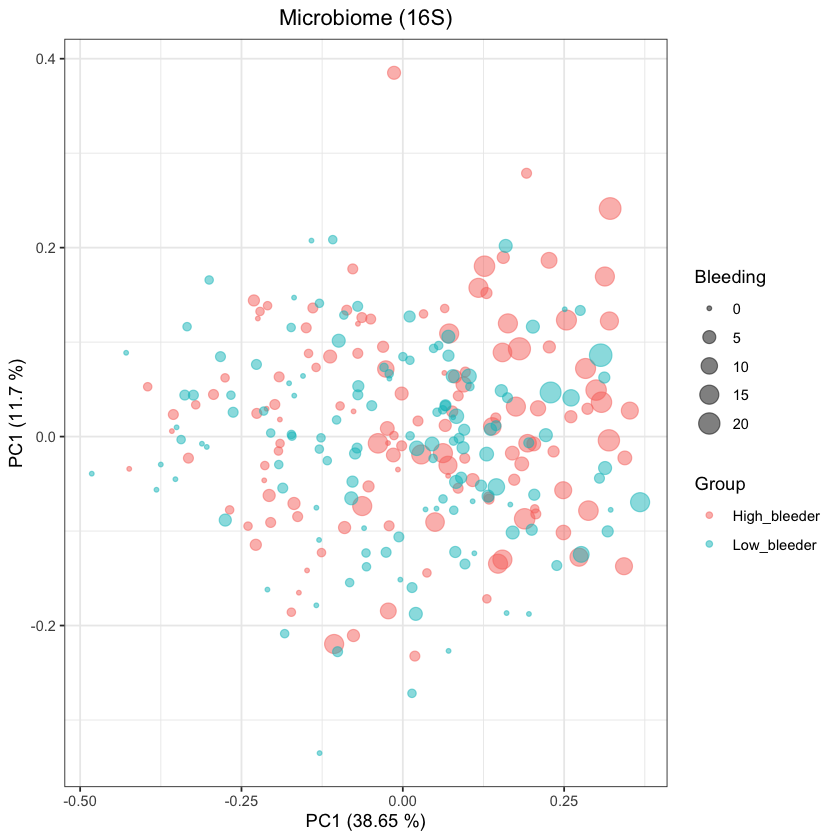

In [34]:
p_pcoa2<-ggplot(data=vectors_f2, aes(x=Axis.1, y=Axis.2, color=Group)) + 
geom_point(aes(size=Bleeding), alpha=0.5) +
   ggtitle("Microbiome (16S)") +
#geom_text(aes(label=Target_field),hjust=0, vjust=0, alpha=0.3, size=1)+
#geom_path(aes(group=Host_ID), alpha=0.1)+
xlab(paste("PC1 (", var_perc[1], " %)", sep=""))+
ylab(paste("PC1 (", var_perc[2], " %)", sep=""))+
theme_bw()+
theme(plot.title = element_text(hjust = 0.5))
p_pcoa2
ggsave(filename=paste(outputPath,"/PCoA_microbiome_by_Group.pdf",sep=""), plot=p_pcoa2, width=5, height=4)

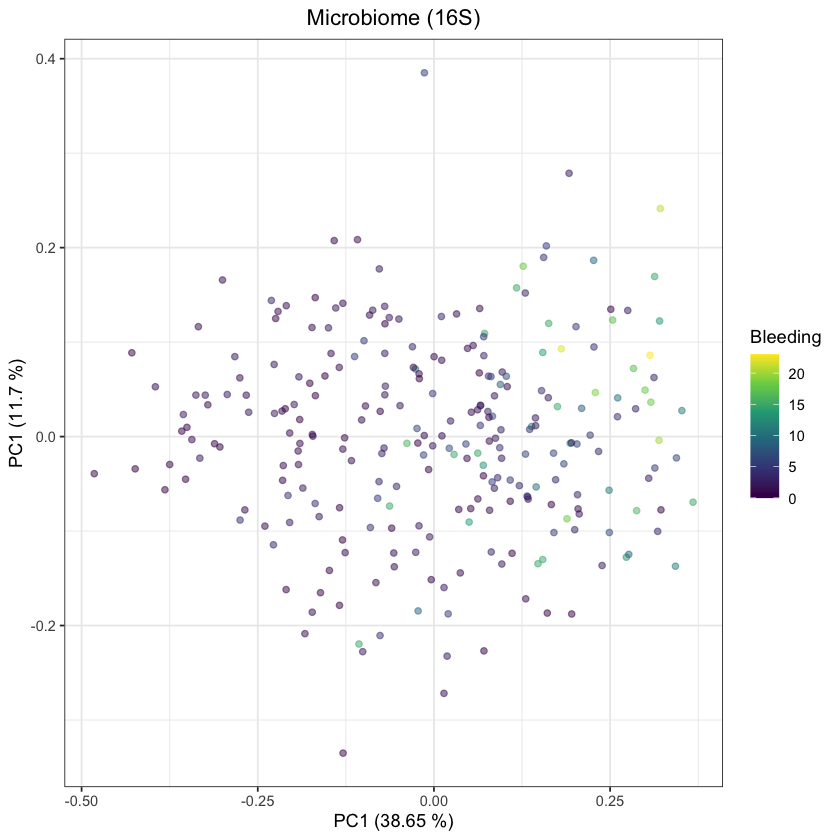

In [35]:
p_pcoa2<-ggplot(data=vectors_f2, aes(x=Axis.1, y=Axis.2, color=Bleeding)) + 
   geom_point(aes(color=Bleeding), alpha=0.5) +
   scale_color_continuous(type = "viridis")+
ggtitle("Microbiome (16S)") +
#geom_text(aes(label=Target_field),hjust=0, vjust=0, alpha=0.3, size=1)+
#geom_path(aes(group=Host_ID), alpha=0.1)+
xlab(paste("PC1 (", var_perc[1], " %)", sep=""))+
ylab(paste("PC1 (", var_perc[2], " %)", sep=""))+
theme_bw()+
theme(plot.title = element_text(hjust = 0.5))
p_pcoa2
ggsave(filename=paste(outputPath,"/PCoA_microbiome_by_Bleeding.pdf",sep=""), plot=p_pcoa2, width=5, height=4)

### PCoA: cytokines profiles

In [22]:
dm_f3<-vegdist(f3, method = "euclidean")
res_f3 <- pcoa(dm_f3)
summary(res_f3)

           Length Class      Mode     
correction     2  -none-     character
note           1  -none-     character
values         6  data.frame list     
vectors    12864  -none-     numeric  
trace          1  -none-     numeric  

In [36]:
vectors_f3<-data.frame(Name=rownames(res_f3$vectors), res_f3$vectors)
vectors_f3<-merge(m3, vectors_f3, by=c(0, 0))
var_perc<-round(res_f3$values$Relative_eig*100, 2)
head(vectors_f3)

Row.names Group        Visit Host_ID Timepoint Day Bleeding Mazza  Halimeter
1 H3003_0   High_bleeder T4    H3003   DAY0        0  1       1.0179 171      
2 H3003_21b High_bleeder T1    H3003   DAY-21    -21 15       1.3571  94      
3 H3003_28  High_bleeder T9    H3003   DAY28      28  2       1.0536 120      
4 H3003_3   High_bleeder T6    H3003   DAY03       3  1       1.0357  87      
5 H3003_7   High_bleeder T7    H3003   DAY07       7  0       1.0000 243      
6 H3007_0   High_bleeder T4    H3007   DAY0        0  1       1.0179  98      
  Age ⋯ Axis.58       Axis.59       Axis.60       Axis.61       Axis.62      
1 38  ⋯  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
2 38  ⋯  3.686144e-06  4.335784e-06 -5.009451e-07 -7.060991e-07 -3.617131e-07
3 38  ⋯ -1.309371e-08 -9.981810e-06 -3.565375e-06 -1.219556e-06  1.259048e-05
4 38  ⋯ -3.550167e-05  5.027801e-06  1.097726e-05  6.229742e-06  9.506504e-06
5 38  ⋯  8.511910e-07 -1.241470e-06 -3.244080e-06 -6.564643e-07 -1.677393e-06
6 37  ⋯  1.090197e-05  1.134848e-05  7.447338e-06 -1.319654e-05  1.097391e-05
  Axis.63       Axis.64       Axis.65       Axis.66       Axis.67      
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
2  3.873302e-07 -4.245833e-06 -3.765665e-06 -1.983293e-06  1.654937e-07
3  8.843853e-06  1.501618e-05 -1.747965e-05 -1.676751e-07  4.722024e-06
4  1.338399e-06  1.400250e-05  1.282477e-05 -1.373451e-05 -3.197345e-06
5  2.096272e-06 -1.235803e-06 -1.090809e-06  4.065565e-06 -9.371346e-07
6 -6.327240e-06 -2.581670e-06 -9.456569e-06  8.426858e-06 -5.115996e-06

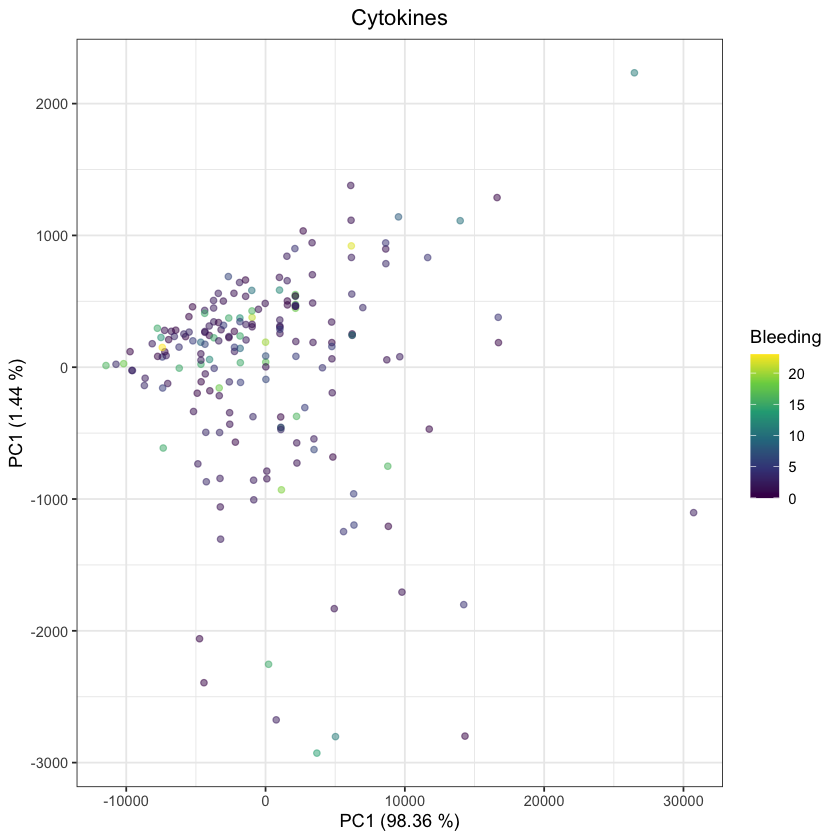

In [37]:
p_pcoa3<-ggplot(data=vectors_f3, aes(x=Axis.1, y=Axis.2, color=Bleeding)) + 
   geom_point(aes(color=Bleeding), alpha=0.5) +
   scale_color_continuous(type = "viridis")+
ggtitle("Cytokines")+
#geom_text(aes(label=Target_field),hjust=0, vjust=0, alpha=0.3, size=1)+
#geom_path(aes(group=Host_ID), alpha=0.1)+
xlab(paste("PC1 (", var_perc[1], " %)", sep=""))+
ylab(paste("PC1 (", var_perc[2], " %)", sep=""))+
theme_bw()+
theme(plot.title = element_text(hjust = 0.5))
p_pcoa3
ggsave(filename=paste(outputPath,"/PCoA_cytokines_by_Bleeding.pdf",sep=""), plot=p_pcoa3, width=5, height=4)

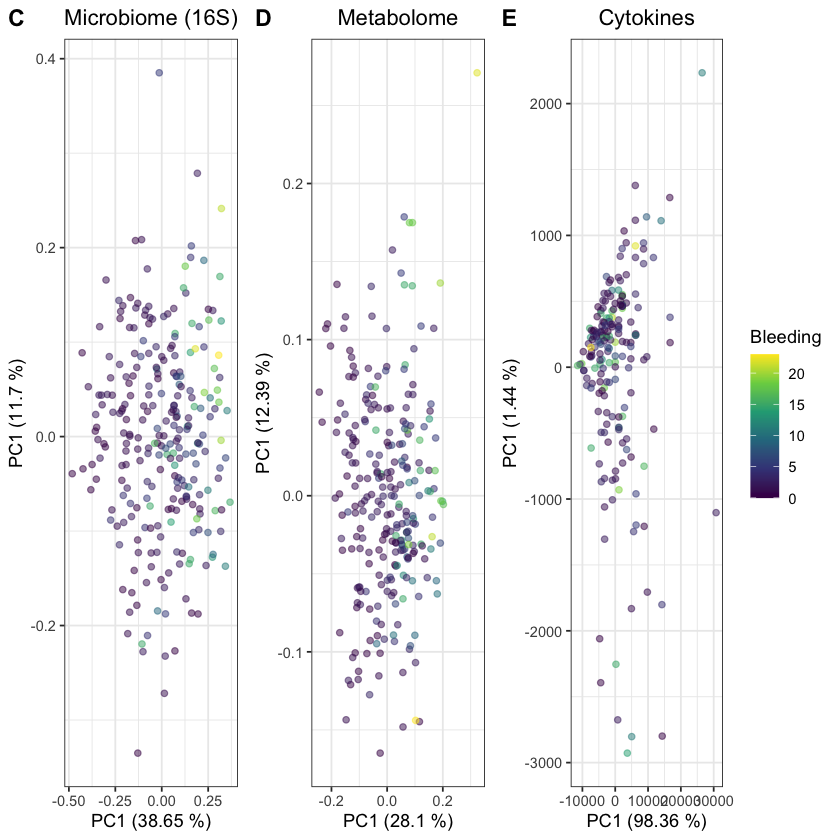

In [38]:
p_pcoa1<-p_pcoa1 + theme(legend.position="none")
p_pcoa2<-p_pcoa2 + theme(legend.position="none")
#p_be<-plot_grid(c_bp, p_pcoa1, p_pcoa2, p_pcoa3, nrow=1, rel_widths = c(1, 1, 1, 1.2), labels = c("B", "C", "D", "E"))
#p_be
p_ce<-plot_grid(p_pcoa2, p_pcoa1,  p_pcoa3, nrow=1, rel_widths = c(1, 1, 1.4), labels = c("C", "D", "E"))
p_ce
#ggsave(filename=paste(outputPath,"/fig1B-E.png",sep=""), plot=p_be, width=15, height=3)
ggsave(filename=paste(outputPath,"/fig1C-E.pdf",sep=""), plot=p_ce, width=10, height=3)

### metabolome: cosine distance

In [26]:
cosine <- function(x) {
  y <- x %*% t(x)
  res <- y / (sqrt(diag(y)) %*% t(sqrt(diag(y))))
  return(res)
}

dm_f1_cosine<-as.dist(cosine(data.matrix(f1_s)))
res_f1_cosine <- pcoa(dm_f1_cosine)
vectors_f1_cosine<-data.frame(Name=rownames(res_f1_cosine$vectors), res_f1_cosine$vectors)
vectors_f1_cosine<-merge(m1_s, vectors_f1_cosine, by=c(0, 0))
var_perc_cosine<-round(res_f1_cosine$values$Relative_eig*100, 2)


In [27]:
res_f1_cosine

$correction
[1] "none" "1"   

$note
[1] "No correction was applied to the negative eigenvalues"

$values
    Eigenvalues  Relative_eig Rel_corr_eig Broken_stick Cum_corr_eig
1    0.49992064  0.0047793398  0.003886380 2.369102e-02  0.003886380
2    0.49991228  0.0047792598  0.003886376 1.983001e-02  0.007772756
3    0.49990365  0.0047791774  0.003886373 1.789951e-02  0.011659128
4    0.49990205  0.0047791620  0.003886372 1.661251e-02  0.015545500
5    0.49989614  0.0047791055  0.003886370 1.564726e-02  0.019431870
6    0.49989274  0.0047790730  0.003886368 1.487506e-02  0.023318238
7    0.49988830  0.0047790305  0.003886366 1.423156e-02  0.027204604
8    0.49988074  0.0047789583  0.003886363 1.367998e-02  0.031090967
9    0.49987620  0.0047789149  0.003886361 1.319736e-02  0.034977329
10   0.49987115  0.0047788666  0.003886359 1.276836e-02  0.038863688
11   0.49986490  0.0047788069  0.003886357 1.238226e-02  0.042750045
12   0.49985721  0.0047787334  0.003886353 1.203126e-02  0.0466363

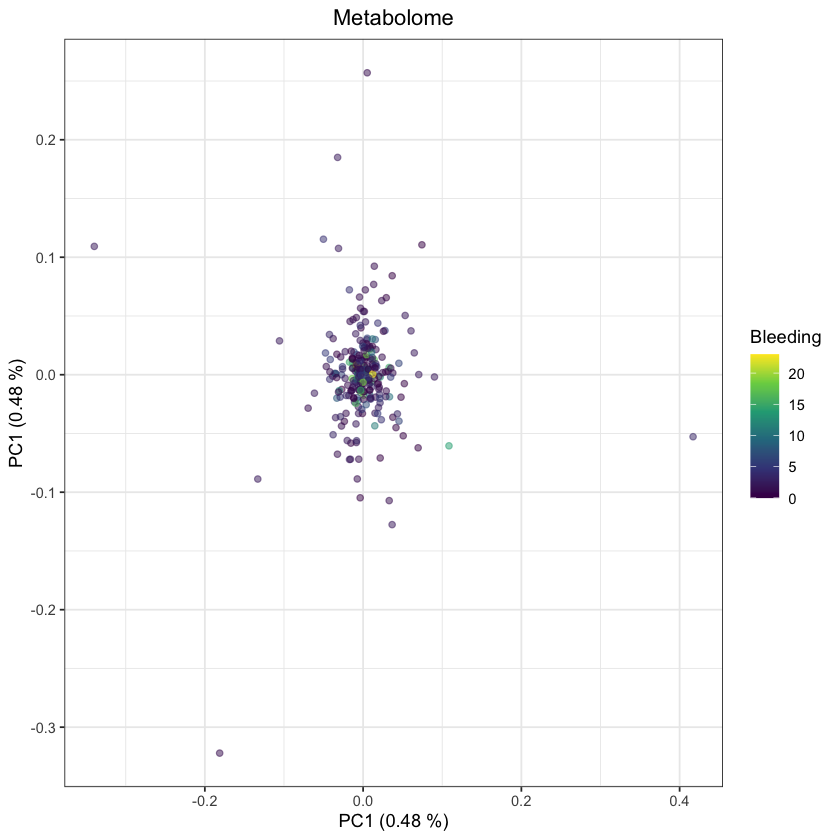

In [28]:
p_pcoa1_cosine<-ggplot(data=vectors_f1_cosine, aes(x=Axis.1, y=Axis.2, color=Bleeding)) + 
   geom_point(aes(color=Bleeding), alpha=0.5) +
   scale_color_continuous(type = "viridis")+
   ggtitle("Metabolome") +
#geom_text(aes(label=Target_field),hjust=0, vjust=0, alpha=0.3, size=1)+
#geom_path(aes(group=Host_ID), alpha=0.1)+
xlab(paste("PC1 (", var_perc_cosine[1], " %)", sep=""))+
ylab(paste("PC1 (", var_perc_cosine[2], " %)", sep=""))+
theme_bw()+
theme(plot.title = element_text(hjust = 0.5))#+
#
p_pcoa1_cosine
ggsave(filename=paste(outputPath,"/PCoA_cosine_metabolome_by_Bleeding.png",sep=""), plot=p_pcoa1_cosine, width=5, height=4)

# Procrustes analysis

In [29]:
#--------------------------------------------------
#PCA using ade4 package
#--------------------------------------------------
dm_f1.pco <- dudi.pco(dm_f1,scan=FALSE, nf=4)
summary(dm_f1.pco)
dm_f1.Axis1<-dm_f1.pco$li[,1]
dm_f1.Axis2<-dm_f1.pco$li[,2]
#--------------------------------------------------
dm_f2.pco <- dudi.pco(dm_f2,scan=FALSE, nf=4)
dm_f2<-dm_f2.pco$li[,1]
dm_f2<-dm_f2.pco$li[,2]

Warning message in dudi.pco(dm_f1, scan = FALSE, nf = 4):
“Non euclidean distance”

Class: pco dudi
Call: dudi.pco(d = dm_f1, scannf = FALSE, nf = 4)

Total inertia: 0.04279

Eigenvalues:
     Ax1      Ax2      Ax3      Ax4      Ax5 
0.010008 0.004415 0.003919 0.002490 0.002075 

Projected inertia (%):
    Ax1     Ax2     Ax3     Ax4     Ax5 
 23.390  10.317   9.159   5.819   4.849 

Cumulative projected inertia (%):
    Ax1   Ax1:2   Ax1:3   Ax1:4   Ax1:5 
  23.39   33.71   42.87   48.68   53.53 

(Only 5 dimensions (out of 117) are shown)



Warning message in dudi.pco(dm_f2, scan = FALSE, nf = 4):
“Non euclidean distance”

Monte-Carlo test
Call: procuste.randtest(df1 = dm_f1.pco$tab, df2 = dm_f2.pco$tab, nrepet = 1000)

Observation: 0.5304568 

Based on 1000 replicates
Simulated p-value: 0.000999001 
Alternative hypothesis: greater 

     Std.Obs  Expectation     Variance 
3.206934e+01 3.047689e-01 4.952639e-05 

pdf 
  2

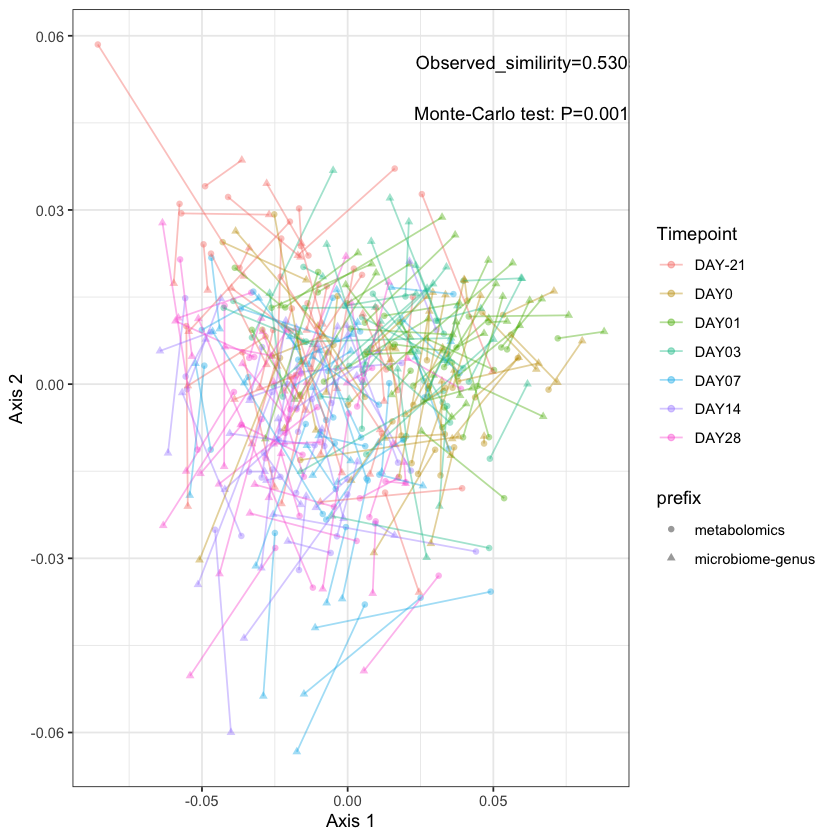

In [30]:
###################################################
# procuste analysis
###################################################
pro <- procuste(dm_f1.pco$tab, dm_f2.pco$tab, nf = 4)
pro.test<-procuste.randtest(dm_f1.pco$tab, dm_f2.pco$tab, 1000)
pro.test
pdf(paste(outputPath, prefix1,"-",prefix2,".procruste.all.pdf",sep=""),15,15)
plot(pro,clab=0.1,cpoint=2, add.p=TRUE)
dev.off()

X_ax<-data.frame(SampleID=rownames(pro$scorX), m1_s, prefix=rep(prefix1, nrow(m1_s)), ax1=pro$scorX$ax1, ax2=pro$scorX$ax2) 
Y_ax<-data.frame(SampleID=rownames(pro$scorY), m1_s, prefix=rep(prefix2, nrow(m1_s)), ax1=pro$scorY$ax1, ax2=pro$scorY$ax2)
ax<-rbind(X_ax, Y_ax)
#--------------------------------------------------
p<-ggplot(ax, aes(x=ax1, y=ax2, color=Timepoint, shape=prefix)) + 
  geom_point(aes(x=ax1, y=ax2, group=SampleID), alpha=0.4)+
  geom_path(aes(x=ax1, y=ax2, group=SampleID), alpha=0.4)+
  annotate("text", label=paste("Observed_similirity=",formatC(pro.test$obs,digits=4,format="f"),sep=""), x=max(ax$ax1)*0.7, y=max(ax$ax2)*0.95)+
  annotate("text", label=paste("Monte-Carlo test: P=",formatC(pro.test$pvalue,digits=4,format="f"),sep=""), x=max(ax$ax1)*0.7, y=max(ax$ax2)*0.8)+
  xlab("Axis 1")+ylab("Axis 2")+
  theme_bw()
p
ggsave(filename=paste(outputPath,"/procrustes-Timepoint.boxplot.pdf",sep=""), plot=p, limitsize=TRUE, width=6, height=5)
#ggplotly(p)




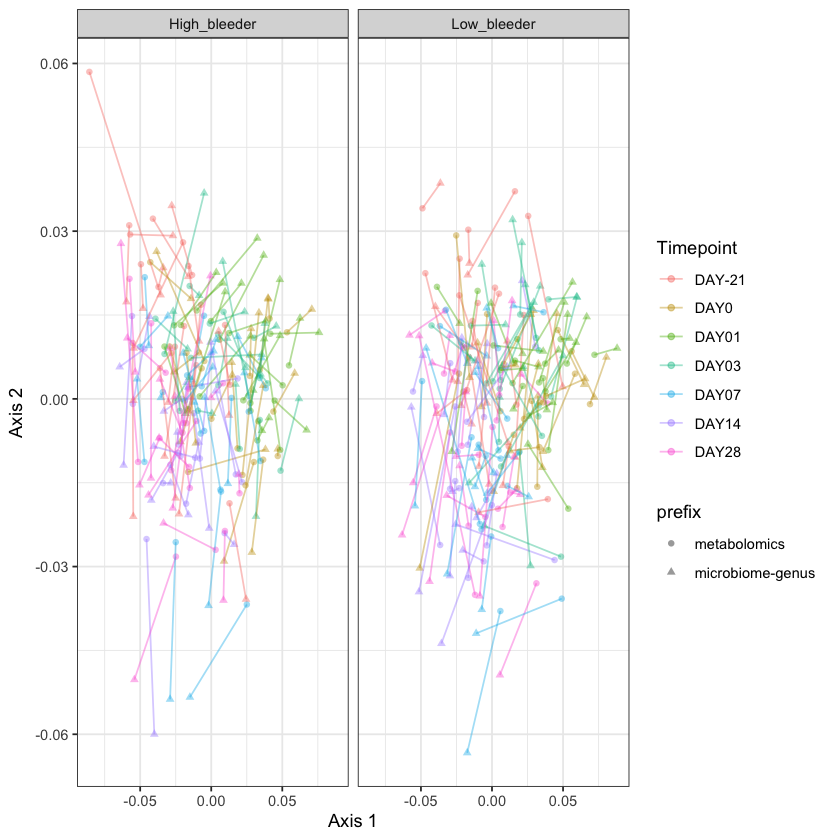

In [31]:
#--------------------------------------------------
p<-ggplot(ax, aes(x=ax1, y=ax2, color=Timepoint, shape=prefix)) + 
  geom_point(aes(x=ax1, y=ax2, group=SampleID), alpha=0.4)+
  geom_path(aes(x=ax1, y=ax2, group=SampleID), alpha=0.4)+ 
  xlab("Axis 1")+ylab("Axis 2")+
  facet_wrap(~ Group)+
  theme_bw()
p
ggsave(filename=paste(outputPath,"/procrustes-Group-Timepoint.boxplot.pdf",sep=""), plot=p, limitsize=TRUE, width=6, height=5)
#ggplotly(p)

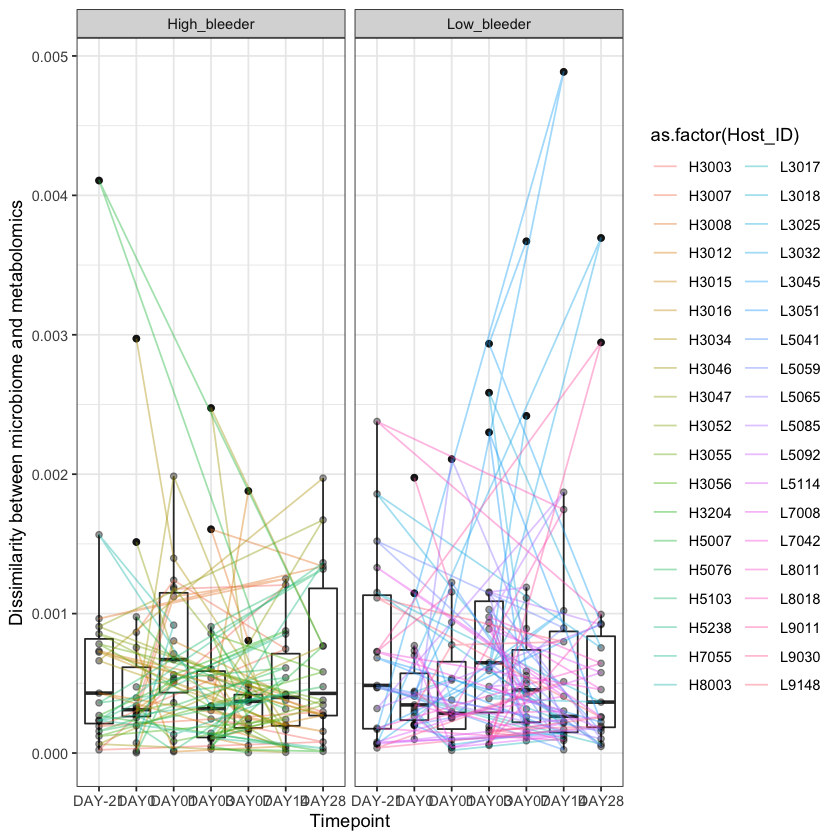

In [32]:
#--------------------------------------------------
len_XY<-rowSums((ax[which(ax$prefix=="metabolomics"), c("ax1", "ax2")] - ax[which(ax$prefix=="microbiome-genus"), c("ax1", "ax2")])^2)
len_XY_m<-data.frame(m1_s, len_XY)

#--------------------------------------------------
p<-ggplot(len_XY_m, aes(x=Timepoint, y=len_XY)) + geom_boxplot() + 
  geom_point(aes(x=Timepoint, y=len_XY, group=Host_ID), alpha=0.4)+
  geom_path(aes(x=Timepoint, y=len_XY, group=Host_ID, color=as.factor(Host_ID)), alpha=0.4)+
  ylab("Dissimilarity between microbiome and metabolomics")+
  facet_wrap(~ Group)+
  theme_bw()
ggsave(filename=paste(outputPath,"/procrustes-dissimilarity-Group-Timepoint.boxplot.pdf",sep=""), plot=p, limitsize=TRUE, width=9, height=5)
p
#ggplotly(p)


	Pearson's product-moment correlation

data:  len_XY_m$len_XY and len_XY_m$Bleeding
t = 0.61548, df = 259, p-value = 0.5388
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.08359145  0.15889911
sample estimates:
       cor 
0.03821644 



	Wilcoxon rank sum test

data:  len_XY by Timepoint
W = 663, p-value = 0.6773
alternative hypothesis: true location shift is not equal to 0


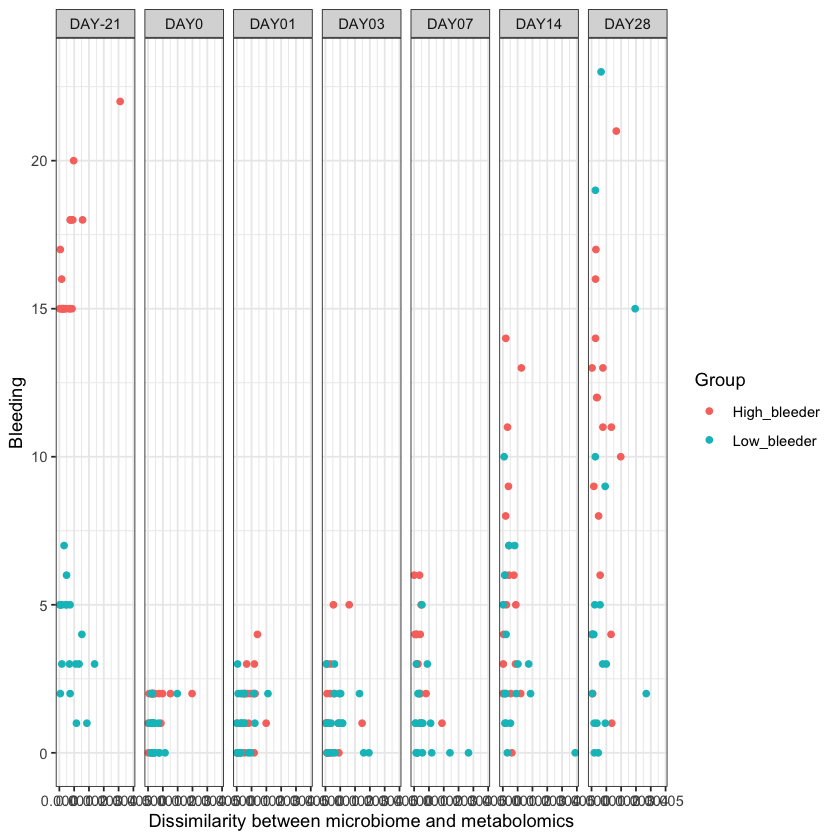

In [33]:
#--------------------------------------------------

p<-ggplot(len_XY_m, aes(x=len_XY, y=Bleeding, colour=Group)) + geom_point() + 
   facet_wrap(~ Timepoint, nrow=1) + theme_bw() + 
   xlab("Dissimilarity between microbiome and metabolomics")
ggsave(filename=paste(outputPath,"/len_XY-Bleeding.scatterplot.pdf",sep=""), plot=p, limitsize=TRUE, width=6, height=5)
p
cor.test(len_XY_m$len_XY, len_XY_m$Bleeding)
len_XY_m_DAY0DAY28<-subset(len_XY_m, Timepoint=="DAY0" | Timepoint=="DAY28")
with(len_XY_m_DAY0DAY28, wilcox.test(len_XY~Timepoint))



##   Correlation analysis of microbiome and metabolome markers

###   Differential abundant Metabolites from Day0 to Day28 -- unpaired Wilcoxon test

In [34]:
m1_EG<-m1[which(m1$Timepoint=="DAY0" | m1$Timepoint=="DAY28"), ]
f1_EG<-f1[which(m1$Timepoint=="DAY0" | m1$Timepoint=="DAY28"), ]
f1_EG<-CleanData(f1_EG)

In [35]:
dim(f1_EG)
data<-f1_EG

[1]   79 1125

In [36]:
group<-factor(m1_EG[, "Timepoint"])
summary(group)

DAY0 DAY28 
   40    39

In [37]:
unpaired_test_res<-BetweenGroup.test(f1_EG, group, p.adj.method = "fdr")
subset(unpaired_test_res, Wilcoxon.test_p.adj <0.05)

Loading required package: ROCR
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



mean_all    
Xanthine_neg                                                0.597664328
Phenylacetic.acid_neg                                      67.641343552
betaine_TSQ                                                53.030387704
phosphoenol.pyruvate_neg                                    0.101763613
D.Fucose_neg                                                0.073924860
X2.deoxy.D.glucose_neg                                      0.074378792
X.2.3.Diaminopropionic.acid_TSQ.                            0.125786757
L.Isoleucine.L.Leucine.4.hydroxy.l.proline_TSQ              1.877359214
X3.Hydroxycapric.acid_neg                                   0.657751357
L.Threonine_TSQ                                             0.014743901
L.Phenylalanine_TSQ                                         1.440369802
Benzenebutanoic.acid_neg                                    0.186990333
Oenanthic.ether_neg                                         1.361822885
Pelargonic.acid_neg                                         1.361822885
Hexadecanedioic.acid_neg                                    0.084168844
Glutaric.acid_neg                                           1.265321475
guanidinoacetate_neg                                        0.006285067
X2.hydroxyglutarate_TSQ                                     3.339467317
S.Methyl.GSH.S.methylglutathione..L.L.Homoglutathione._pos  0.074975795
L.Aspartic.acid_TSQ                                         0.276424272
Leu.Gly_neg                                                 0.131466955
D.tryptophan_neg                                            0.085943060
L.tryptophan_neg                                            0.085943060
deoxycarnitine_TSQ                                         25.365220323
Fucose.1.phosphate.L.Fuculose.1.phosphate_neg               0.029183262
L.Methionine.S.oxide_neg                                    0.048835198
Oxalureate_neg                                              0.003510744
Tyrosol_neg                                                 0.022434219
Uridine_TSQ                                                 0.043832096
X.2.3.dihydroxybenzoate_neg.                                0.187189565
⋮                                                          ⋮           
Uridine.5..monophosphate.1_TSQ                              0.124461393
Hydroxybutyrylcarnitine_pos                                 0.001467074
L.threonine._neg                                            0.653587073
methyl.L.histidine_pos                                      0.052233183
X.5.6.Dihydroxyindole_pos.                                  0.365884766
Glucose.6.phosphate_TSQ                                     1.135329666
Gaidic.acid_neg                                             0.521583015
Diaminopimelic.acid_pos                                     0.025621662
X.ll.2.6.diaminoheptanedioate_pos.                          0.026083027
Asp.Leu_pos                                                 0.103713529
anserine1_TSQ                                               0.016986673
Pivaloylcarnitine_pos                                       0.038995185
X2.Methylbutyroylcarnitine..3.Methylbutyrylcarnitine_pos    0.039355992
Hypoxanthine_neg                                            9.108442740
L.Asparagine_neg                                            0.013050535
METHACHOLINE.like_pos                                       4.718245213
L.Acetylcarnitine_neg                                       0.022374223
creatinine_TSQ                                              0.154372969
Fructose.6.phosphate_TSQ                                    0.356649511
X4.Methoxycinnamic.acid_pos                                 0.005217420
Cytidine.monophosphate_TSQ                                  0.041416131
L.Aspartic.Acid_pos                                         0.586001323
D.Aspartic.Acid_pos                                         0.586003678
Iminodiacetic.acid_pos                                      0.585998415
Aspartic.Acid_pos          

In [38]:
dim(subset(unpaired_test_res, Wilcoxon.test_p.adj <0.05))

[1] 343  23

###   Differential abundant Metabolites from Day0 to Day28 -- paired Wilcoxon test

In [39]:
m1_EG_paired<-m1_EG[which(m1_EG$Host_ID!="H8003"),]
f1_EG_paired<-f1_EG[which(m1_EG$Host_ID!="H8003"),]
paired_test_res<-BetweenGroup.test(f1_EG_paired, factor(m1_EG_paired[, "Timepoint"]), p.adj.method = "fdr")


In [40]:
paired_test_res_sig<-subset(paired_test_res, Wilcoxon.test_p.adj <0.05)


In [41]:
paste(outpath, "DAY0_VS_DAY28_paired_test_results_sig.310.xls", sep="")

ERROR: Error in paste(outpath, "DAY0_VS_DAY28_paired_test_results_sig.310.xls", : object 'outpath' not found


In [ ]:
sink()

In [ ]:
#sink(paste(outputPath, "DAY0_VS_DAY28_paired_test_results_sig.310.xls", sep=""))
write.table(paired_test_res_sig, paste(outputPath, "DAY0_VS_DAY28_paired_test_results_sig.310.xls", sep=""), 
            quote=F, sep="\t", row.names=TRUE)
#sink(NULL)

###  Heatmap of the differential abundant Metabolites from Day0 to Day28 

In [ ]:
f1_EG_sig<-f1_EG[, rownames(subset(paired_test_res, Wilcoxon.test_p.adj <0.05))]
f1_EG_sig<-f1_EG_sig[order(m1_EG$Timepoint), ]
f1_EG_sig_log<-log.mat(f1_EG_sig)
pheatmap(t(f1_EG_sig_log), cellwidth = 2, cellheight = 1, fontsize_row = 1, frontsize_col=2, cluster_rows=T, cluster_cols=F, filename = paste(outputPath,"/EG.metabo.sig.pheatmap_t.pdf",sep=""))

pheatmap(f1_EG_sig_log, cellwidth =3, cellheight = 2, fontsize_row = 2, frontsize_col=0.5, cluster_rows=F, cluster_cols=T, filename = paste(outputPath,"/EG.metabo.sig.pheatmap.pdf",sep=""))

f1_s_sig<-f1_s[, rownames(subset(paired_test_res, Wilcoxon.test_p.adj <0.05))]


###   Identified microbiome markers

In [ ]:
MiG_list<-c('Lep_Leptotrichia.','Fus_Fusobacterium.','Por_Porphyromonas.','Por_Tannerella.','Cam_Campylobacter.','Pas_Aggregatibacter.','Lac_Johnsonella.','Pre_Prevotella.','Vei_Selenomonas.','Lac_Dorea.','Pep_Peptoclostridium.','Lac_Catonella.','TM7_TM7.','Gem_Gemella.','Lac_Lachnoanaerobaculum.','Com_Comamonas.','Act_Actinomycetaceae_Group.','Par_Prevotella.','Act_Actinobaculum.','Spi_Treponema.','Com_Hylemonella.','Aer_Abiotrophia.','Por_Paludibacter.','Lac_Lachnospiraceae_Group.','Rum_Ruminococcaceae_Group.','SR1_SR1.','Det_TG5.','Cor_Atopobium.', 'Mic_Rothia.','Str_Streptococcus.','Bur_Lautropia.','Pas_Haemophilus.','Act_Actinomyces.','Str_Streptococcaceae_Group.','Wil_Williamsia.')
MiG_list_s<-intersect(MiG_list, colnames(f2))
f2_s_sig<-f2_s[, MiG_list_s]

###   Corrlation between microbiome and metabolomics markers

In [ ]:
cor_mat<-cor(f1_s_sig, f2_s_sig, method="spearman")
pheatmap(cor_mat, cellwidth =4, cellheight = 2, fontsize_row = 2, frontsize_col=0.5, cluster_rows=T, cluster_cols=T, filename = paste(outputPath,"/metabo-microbio.corr.pheatmap.pdf",sep=""))
pheatmap(t(cor_mat),  cellwidth =1, cellheight = 4, fontsize_row = 2, frontsize_col=0.5, cluster_rows=T, cluster_cols=T, filename = paste(outputPath,"/metabo-microbio.corr.pheatmap_t.pdf",sep=""))

pdf(paste(outputPath,"/",prefix1,"-",prefix2,"_corrplot.pdf",sep=""))
corrplot.mixed(cor_mat)
dev.off()




In [ ]:
head(cor_mat)

In [ ]:
#--------------------------------------------------
#   host outilers
#--------------------------------------------------
p<-ggplot(m1[order(m1$Timepoint),], aes(x=Timepoint, y=Bleeding)) + 
  geom_boxplot()+
  #geom_boxplot(outlier.shape = NA) + 
  #geom_jitter(position=position_jitterdodge(jitter.width= 0.2,dodge.width = 0.8),size=1,aes(fill=Group),alpha=0.4) +
  geom_point(aes(x=Timepoint, y=Bleeding, group=Host_ID), alpha=0.4)+
  geom_path(aes(x=Timepoint, y=Bleeding, group=Host_ID, color=Host_ID), alpha=0.4)+ 
  facet_wrap(~ Group)+
  theme_bw()
ggsave(filename=paste(outputPath,"/Bleeding.boxplot.pdf",sep=""), plot=p, limitsize=TRUE, width=8, height=5)
ggplotly(p)
#--------------------------------------------------
Host_IDs_3<-subset(m1, Timepoint=="DAY28" & Bleeding<3)$Host_ID
m1_Host_IDs_3<-m1[which(m1$Host_ID %in% Host_IDs_3),]
p<-ggplot(m1_Host_IDs_3[order(m1_Host_IDs_3$Timepoint),], aes(x=Timepoint, y=Bleeding)) + 
  geom_boxplot()+
  #geom_boxplot(outlier.shape = NA) + 
  #geom_jitter(position=position_jitterdodge(jitter.width= 0.2,dodge.width = 0.8),size=1,aes(fill=Group),alpha=0.4) +
  geom_point(aes(x=Timepoint, y=Bleeding, group=Host_ID), alpha=0.4)+
  geom_path(aes(x=Timepoint, y=Bleeding, group=Host_ID, color=Host_ID), alpha=0.4)+ 
  facet_wrap(~ Group)+
  theme_bw()
ggsave(filename=paste(outputPath,"/m1_Host_IDs_Bleeding3_atDay28.boxplot.pdf",sep=""), plot=p, limitsize=TRUE, width=8, height=5)
ggplotly(p)

In [ ]:
#--------------------------------------------------
head(m1)
Host_IDs_45<-subset(m1, Timepoint=="DAY28" & Bleeding>3 & Bleeding<5)$Host_ID
m1_Host_IDs_45<-m1[which(m1$Host_ID %in% Host_IDs_45),]
p<-ggplot(m1_Host_IDs_45[order(m1_Host_IDs_45$Timepoint),], aes(x=Timepoint, y=Bleeding)) + 
  geom_boxplot()+
  #geom_boxplot(outlier.shape = NA) + 
  #geom_jitter(position=position_jitterdodge(jitter.width= 0.2,dodge.width = 0.8),size=1,aes(fill=Group),alpha=0.4) +
  geom_point(aes(x=Timepoint, y=Bleeding, group=Host_ID), alpha=0.4)+
  geom_path(aes(x=Timepoint, y=Bleeding, group=Host_ID, color=Host_ID), alpha=0.4)+ 
  facet_wrap(~ Group)+
  theme_bw()
ggsave(filename=paste(outputPath,"/m1_Host_IDs_Bleeding45_atDay28.boxplot.pdf",sep=""), plot=p, limitsize=TRUE, width=8, height=5)
ggplotly(p)

#--------------------------------------------------
pdf(paste(outputPath, prefix1,"-",prefix2,".label.procruste.pdf",sep=""),12,12)
par(mar=c(6,6,6,6))
plot(pro$scorX$ax1, pro$scorX$ax2,pch=21, cex=2, col="white", bg="green", xlab="Axis1", ylab="Axis2",cex.axis=2,cex.lab=1,
     xlim=c((min(pro$scorX$ax1)-0.1*(max(pro$scorX$ax1)-min(pro$scorX$ax1))),(max(pro$scorX$ax1)+0.2*(max(pro$scorX$ax1)-min(pro$scorX$ax1)))), 
     ylim=c((min(pro$scorX$ax2)-0.1*(max(pro$scorX$ax2)-min(pro$scorX$ax2))),(max(pro$scorX$ax2)+0.2*(max(pro$scorX$ax2)-min(pro$scorX$ax2)))))
points(pro$scorY$ax1, pro$scorY$ax2,pch=21, cex=2, col="white", bg="red",cex.axis=2,cex.lab=1,
       xlim=c((min(pro$scorY$ax1)-0.1*(max(pro$scorY$ax1)-min(pro$scorY$ax1))),(max(pro$scorY$ax1)+0.2*(max(pro$scorY$ax1)-min(pro$scorY$ax1)))), 
       ylim=c((min(pro$scorY$ax2)-0.1*(max(pro$scorY$ax2)-min(pro$scorY$ax2))),(max(pro$scorY$ax2)+0.2*(max(pro$scorY$ax2)-min(pro$scorY$ax2)))))
segments(x0=pro$scorX$ax1, y0=pro$scorX$ax2,x1=pro$scorY$ax1, y1=pro$scorY$ax2,ljoin=2,lend=2,col="#0000ff22",lwd=3 )
x.label<-0.5*(pro$scorY$ax1+pro$scorX$ax1)
y.label<-0.5*(pro$scorY$ax2+pro$scorX$ax2)
scatterutil.eti.circ(x.label, y.label, rownames(pro$scorX),1)
legend("topleft",c(filename1,filename2), pch=20, col=c("green","red"), pt.cex=2,cex=1)
mtext(paste("Observed_similirity=",formatC(pro.test$obs,digits=4,format="f"),sep=""),outer=FALSE,line=-2,adj=0.9)
mtext(paste("Monte-Carlo test: P_value=",formatC(pro.test$pvalue,digits=4,format="f"),sep=""),outer=FALSE,line=-3,adj=0.9)     
dev.off()


#--------------------------------------------------



# Correlation between Rothia and betaine

In [ ]:
rowSums(f2_s)

In [ ]:
grep('betaine', names(f1_s), value = TRUE)
which(names(f2_s)=='Mic_Rothia.')

In [ ]:
betaine_rb<-f1_s[, 'betaine_TSQ']
Rothia_rb<-f2_s[, 'Mic_Rothia.']
rb<-data.frame(m2_s, betaine_rb, Rothia_rb)
head(rb)


In [ ]:
dim(rb)

In [ ]:
detach(package:dplyr)
require('dplyr')
rb_summ<-rb %>% group_by(Timepoint) %>% summarise(
    mean_plaque_weight=mean(Plaque_weight, na.rm = TRUE),
    SEM_plaque_weight=sd(Plaque_weight, na.rm = TRUE)/length(Plaque_weight),
    mean_Delta_R30=mean(Delta_R30, na.rm = TRUE), 
    SEM_Delta_R30=sd(Delta_R30, na.rm = TRUE)/length(Delta_R30),
    mean_Delta_R70=mean(Delta_R70, na.rm = TRUE),
    SEM_Delta_R70=sd(Delta_R70, na.rm = TRUE)/length(Delta_R70),
    mean_Delta_R120=mean(Delta_R120, na.rm = TRUE),
    SEM_Delta_R120=sd(Delta_R120, na.rm = TRUE)/length(Delta_R120),
    median_sps=median(sps, na.rm = TRUE),
    mean_sps=mean(sps, na.rm = TRUE),
    SEM_sps=sd(sps, na.rm = TRUE)/length(sps),
    mean_betaine_rb=mean(betaine_rb), 
    mean_Rothia_rb=mean(Rothia_rb),
    mean_betaine_ab_30=mean(betaine_rb*Delta_R30), 
    mean_Rothia_ab_30=mean(Rothia_rb*Delta_R30),
    mean_betaine_ab_pw=mean(betaine_rb*Plaque_weight, na.rm=TRUE), 
    mean_Rothia_ab_pw=mean(Rothia_rb*Plaque_weight, na.rm=TRUE),
    SEM_betaine_rb=sd(betaine_rb)/length(betaine_rb), 
    SEM_Rothia_rb=sd(Rothia_rb)/length(Rothia_rb),
    SEM_betaine_ab_30=sd(betaine_rb*Delta_R30)/length(betaine_rb), 
    SEM_Rothia_ab_30=sd(Rothia_rb*Delta_R30)/length(Rothia_rb),
    SEM_betaine_ab_pw=sd(betaine_rb*Plaque_weight, na.rm=TRUE)/length(betaine_rb), 
    SEM_Rothia_ab_pw=sd(Rothia_rb*Plaque_weight, na.rm=TRUE)/length(Rothia_rb)
)
rb_summ

In [ ]:
rb_summ<-rb_summ %>% mutate( Day=c(-21, 0, 1, 3, 7, 14, 28))

### Temporal dynamics of delta values indicating the plaque maturity using QLF

In [ ]:
QLF_summ<-rb_summ[, c(1, grep("Delta" , colnames(rb_summ)), grep("sps", colnames(rb_summ)))]
head(QLF_summ)

In [ ]:
qlf<-ggplot(rb_summ, aes(x=Day, y=mean_sps, group=1)) + 
  #Delta_R30
  geom_point(aes(x=Day, y=mean_Delta_R30), alpha=0.4)+
  geom_path(aes(x=Day, y=mean_Delta_R30), alpha=0.4, color="#A9A9A9")+
  geom_errorbar(aes(ymin=mean_Delta_R30-SEM_Delta_R30, ymax=mean_Delta_R30+SEM_Delta_R30), width=.1, alpha=0.3) + 
  #Delta_R70
  geom_point(aes(x=Day, y=mean_Delta_R70), alpha=0.4)+
  geom_path(aes(x=Day, y=mean_Delta_R70), alpha=0.4, color="#696969")+
  geom_errorbar(aes(ymin=mean_Delta_R70-SEM_Delta_R70, ymax=mean_Delta_R70+SEM_Delta_R70), width=.1, alpha=0.3) + 
  #Delta_R120
  geom_point(aes(x=Day, y=mean_Delta_R120), alpha=0.4)+
  geom_path(aes(x=Day, y=mean_Delta_R120), alpha=0.4, color="#000000")+
  geom_errorbar(aes(ymin=mean_Delta_R120-SEM_Delta_R120, ymax=mean_Delta_R120+SEM_Delta_R120), width=.1, alpha=0.3) +
  
  #SPS
  geom_point(aes(x=Day, y= mean_sps*100), shape="diamond", size=4, color = "#D55E00")+ #geom_bar(stat = "identity", alpha=0.5, width=0.01) +
  geom_path(aes(x=Day, y=mean_sps*100), alpha=0.3, color = "#D55E00")+ #c("#D55E00", "#0072B2")
  scale_y_continuous(sec.axis = sec_axis(~(.)/100, name = "Mean SPS")) +
  ylab("Mean DELTA value +/- SEM")+
  #scale_color_identity(name = 'the fill', guide = 'legend',labels = c("Delta_30","Delta_70","Delta_120","SPS")) +
  scale_colour_manual(name = 'QLF data',
         values =c("#A9A9A9"="#A9A9A9","#696969"="#696969","#000000"="#000000","#D55E00"="#D55E00"), 
                      labels = c("Delta_30","Delta_70","Delta_120","SPS"))+
  theme_bw()+
  theme(legend.position = "right",
        axis.line.y.right = element_line(color = "#D55E00"),  
        axis.ticks.y.right = element_line(color = "#D55E00"),
        axis.text.y.right = element_text(color = "#D55E00"), 
        axis.title.y.right = element_text(color = "#D55E00")
        )
qlf
ggsave(filename=paste("QLF.ggplot.pdf",sep=""), qlf, width=4, height=3)



### Temporal profiles of mean plaque weight

In [ ]:
p<-ggplot(rb_summ, aes(x=Day, y=mean_plaque_weight)) + 
  geom_point(aes(x=Day, y=mean_plaque_weight), alpha=0.4)+
  geom_path(aes(x=Day, y=mean_plaque_weight), alpha=0.4)+
  geom_errorbar(aes(ymin=mean_plaque_weight-SEM_plaque_weight, ymax=mean_plaque_weight+SEM_plaque_weight), width=.1, alpha=0.3) +    
  ylab("The plaque weight (g)")+
  theme_bw()+ theme(legend.position='none')
p
ggsave(filename=paste("mean_plaque_weight.ggplot.pdf",sep=""),p, width=4, height=3)

### relative abundance

In [ ]:
ylim.prim <- c(0, 65)   # in this example, bleeding
ylim.sec <- c(0, 0.1)  # in this example, AUROC
b <- diff(ylim.prim)/diff(ylim.sec)
a <- b*(ylim.prim[1] - ylim.sec[1])
cor.test(rb_summ$mean_betaine_rb, rb_summ$mean_Rothia_rb)

p<-ggplot(rb_summ, aes(x=Timepoint, y=mean_betaine_rb, group = 1)) + 
  geom_point(aes(x=Timepoint, y=mean_betaine_rb), alpha=0.4)+
  geom_path(aes(x=Timepoint, y=mean_betaine_rb), alpha=0.4)+
  ylab("The conc of betaine")+
  geom_point(aes(x=Timepoint, y= a + mean_Rothia_rb*b), shape="diamond", size=4, color = "#D55E00")+ #geom_bar(stat = "identity", alpha=0.5, width=0.01) +
  geom_path(aes(x=Timepoint, y=a + mean_Rothia_rb*b), alpha=0.3, color = "#D55E00")+ #c("#D55E00", "#0072B2")
    #coord_flip()+ # if want to filp coordinate
    scale_y_continuous(sec.axis = sec_axis(~(. - a)/b, name = "The rel abd of Rothia")) +
    theme_bw()+ theme(legend.position='none')+
    #theme(axis.text.x = element_text(angle = 90, hjust = 1))+
    theme(axis.line.y.right = element_line(color = "#D55E00"),  
        axis.ticks.y.right = element_line(color = "#D55E00"),
        axis.text.y.right = element_text(color = "#D55E00"), 
        axis.title.y.right = element_text(color = "#D55E00")
        )
p
ggsave(filename=paste("betaine_Rothia.rb.ggplot.pdf",sep=""),p, width=5, height=4)

In [ ]:
ylim.prim <- c(0, 65)   # in this example, bleeding
ylim.sec <- c(0, 0.1)  # in this example, AUROC
b <- diff(ylim.prim)/diff(ylim.sec)
a <- b*(ylim.prim[1] - ylim.sec[1])

p<-ggplot(rb_summ, aes(x=Day, y=mean_betaine_rb, group = 1)) + 
  geom_point(aes(x=Day, y=mean_betaine_rb), alpha=0.4)+
  geom_path(aes(x=Day, y=mean_betaine_rb), alpha=0.4)+
  ylab("The conc of betaine")+
  geom_point(aes(x=Day, y= a + mean_Rothia_rb*b), shape="diamond", size=4, color = "#D55E00")+ #geom_bar(stat = "identity", alpha=0.5, width=0.01) +
  geom_path(aes(x=Day, y=a + mean_Rothia_rb*b), alpha=0.3, color = "#D55E00")+ #c("#D55E00", "#0072B2")
    #coord_flip()+ # if want to filp coordinate
    scale_y_continuous(sec.axis = sec_axis(~(. - a)/b, name = "The rel abd of Rothia")) +
    theme_bw()+ theme(legend.position='none')+
    #theme(axis.text.x = element_text(angle = 90, hjust = 1))+
    theme(axis.line.y.right = element_line(color = "#D55E00"),  
        axis.ticks.y.right = element_line(color = "#D55E00"),
        axis.text.y.right = element_text(color = "#D55E00"), 
        axis.title.y.right = element_text(color = "#D55E00")
        )
p
ggsave(filename=paste("betaine_Rothia.rb.Day.ggplot.pdf",sep=""),p, width=4, height=3)

### biomass: relative abundance data normalized by plaque weight

In [ ]:
rb_summ$mean_Rothia_ab_pw

In [ ]:
range(rb_summ$mean_betaine_ab_pw)

In [ ]:
cor.test(rb_summ$mean_betaine_rb, rb_summ$mean_Rothia_ab_pw)


In [ ]:


ylim.prim <- c(0, 65)   # in this example, betaine
ylim.sec <- c(0, 0.0005)  # in this example, Rothia
b <- ifelse(diff(ylim.prim)> diff(ylim.sec), diff(ylim.prim)/diff(ylim.sec), diff(ylim.sec)/diff(ylim.prim)) 
b
a <- ylim.prim[1] - ylim.sec[1]
a

p<-ggplot(rb_summ, aes(x=Timepoint, y=mean_betaine_rb, group = 1)) + 
  geom_point(aes(x=Timepoint, y=mean_betaine_rb), alpha=0.4)+
  geom_path(aes(x=Timepoint, y=mean_betaine_rb), alpha=0.4)+
  ylab("The abs cons of betaine")+
  geom_point(aes(x=Timepoint, y= a+ mean_Rothia_ab_pw*b), shape="diamond", size=4, color = "#D55E00")+ #geom_bar(stat = "identity", alpha=0.5, width=0.01) +
  geom_path(aes(x=Timepoint, y= a+ mean_Rothia_ab_pw*b), alpha=0.3, color = "#D55E00")+ #c("#D55E00", "#0072B2")
    #coord_flip()+ # if want to filp coordinate
    scale_y_continuous(sec.axis = sec_axis(~(.-a)/b, name = "The abs abd of Rothia")) +
    theme_bw()+ theme(legend.position='none')+
    #theme(axis.text.x = element_text(angle = 90, hjust = 1))+
    theme(axis.line.y.right = element_line(color = "#D55E00"),  
        axis.ticks.y.right = element_line(color = "#D55E00"),
        axis.text.y.right = element_text(color = "#D55E00"), 
        axis.title.y.right = element_text(color = "#D55E00")
        )
p
ggsave(filename=paste("betaine_Rothia_normByPlaqueweight.ggplot.pdf",sep=""),p, width=5, height=4)


In [ ]:
ylim.prim <- c(0, 65)   # in this example, betaine
ylim.sec <- c(0, 0.0005)  # in this example, Rothia
b <- ifelse(diff(ylim.prim)> diff(ylim.sec), diff(ylim.prim)/diff(ylim.sec), diff(ylim.sec)/diff(ylim.prim)) 
a <- ylim.prim[1] - ylim.sec[1]

p<-ggplot(rb_summ, aes(x=Day, y=mean_betaine_ab_pw, group = 1)) + 
  geom_point(aes(x=Day, y=mean_betaine_rb), alpha=0.4)+
  geom_path(aes(x=Day, y=mean_betaine_rb), alpha=0.4)+
  ylab("The abs cons of betaine")+
  geom_point(aes(x=Day, y= a+ mean_Rothia_ab_pw*b), shape="diamond", size=4, color = "#D55E00")+ #geom_bar(stat = "identity", alpha=0.5, width=0.01) +
  geom_path(aes(x=Day, y= a+ mean_Rothia_ab_pw*b), alpha=0.3, color = "#D55E00")+ #c("#D55E00", "#0072B2")
    #coord_flip()+ # if want to filp coordinate
    scale_y_continuous(sec.axis = sec_axis(~(.-a)/b, name = "The abs abd of Rothia")) +
    theme_bw()+ theme(legend.position='none')+
    #theme(axis.text.x = element_text(angle = 90, hjust = 1))+
    theme(axis.line.y.right = element_line(color = "#D55E00"),  
        axis.ticks.y.right = element_line(color = "#D55E00"),
        axis.text.y.right = element_text(color = "#D55E00"), 
        axis.title.y.right = element_text(color = "#D55E00")
        )
p
ggsave(filename=paste("betaine_Rothia_normByPlaqueweight.Day.ggplot.pdf",sep=""),p, width=4, height=3)


### relative abundance data normalized by delta_R30

In [ ]:
range(rb_summ$mean_betaine_ab_30)

In [ ]:
range(rb_summ$mean_Rothia_ab_30)
cor.test(rb_summ$mean_betaine_ab_30, rb_summ$mean_Rothia_ab_30)

In [ ]:
ylim.prim <- c(7100, 23000)   # in this example, betaine
ylim.sec <- c(0.5, 3)  # in this example, Rothia
b <- diff(ylim.prim)/diff(ylim.sec)
a <- ylim.prim[1] - ylim.sec[1]


p<-ggplot(rb_summ, aes(x=Timepoint, y=mean_betaine_ab_30, group = 1)) + 
  geom_point(aes(x=Timepoint, y=mean_betaine_ab_30), alpha=0.4)+
  geom_path(aes(x=Timepoint, y=mean_betaine_ab_30), alpha=0.4)+
  ylab("The abs abd of betaine")+
  geom_point(aes(x=Timepoint, y= a + mean_Rothia_ab_30*b), shape="diamond", size=4, color = "#D55E00")+ #geom_bar(stat = "identity", alpha=0.5, width=0.01) +
  geom_path(aes(x=Timepoint, y=a + mean_Rothia_ab_30*b), alpha=0.3, color = "#D55E00")+ #c("#D55E00", "#0072B2")
    #coord_flip()+ # if want to filp coordinate
    scale_y_continuous(sec.axis = sec_axis(~(. - a)/b, name = "The abs abd of Rothia")) +
    theme_bw()+ theme(legend.position='none')+
    #theme(axis.text.x = element_text(angle = 90, hjust = 1))+
    theme(axis.line.y.right = element_line(color = "#D55E00"),  
        axis.ticks.y.right = element_line(color = "#D55E00"),
        axis.text.y.right = element_text(color = "#D55E00"), 
        axis.title.y.right = element_text(color = "#D55E00")
        )
p
ggsave(filename=paste("betaine_Rothia_normByR30.ggplot.pdf",sep=""),p, width=5, height=4)

In [ ]:
library('compositions')
f2_s_clr<-apply(f2_s, 1, clr)
f2_s_alr<-apply(f2_s, 1, function(x) alr(x, ivar =34))


In [ ]:
sessionInfo()